# Value fn RMSE, random chain

Experiment: (Jan 11, 2021), via `/network/tmp1/chenant/ant/sr_trace/2021-01-30/19-32-39`

Today: February 3, 2021

## NOTE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files

Read the dfs, filter out the LSF value function agent from the `1228` runs and use the new LSF value function agent from the `1230` runs (which has the elig traces) for comparison.

In [2]:
sfAg_in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-30/19-32-39/progress.csv'

pd_df_sep = '\|\|'

In [3]:
# LSF value function agent
sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)

<ipython-input-3-baf4a30cceb4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)


Filter and concat into a single big df

In [4]:
withDate_Data_df = sf_ag_raw_df.copy(deep=True)
print(len(withDate_Data_df))
withDate_Data_df[0:3]

980000


,"2021-01-30 19:32:39,848",num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2021-01-30 19:32:39,927",400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,...,160,1.0,0.569215,0.569215,0.0,0.112414,0.00625,0.000329,0.0,None
1,"2021-01-30 19:32:39,938",400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,...,28,0.0,0.569215,0.569215,0.0,0.112414,0.00000,0.000000,0.0,None
2,"2021-01-30 19:32:39,957",400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,...,68,1.0,0.568350,0.568350,0.0,0.110165,0.01442,0.000759,0.0,None


#### Manually drop the date time column

In [5]:
Data_df = withDate_Data_df.copy(deep=True)
del Data_df['2021-01-30 19:32:39,848']
print(list(Data_df))
print(len(Data_df))
Data_df[0:3]

['num_episodes', 'envCls_name', 'env_kwargs', 'agentCls_name', 'seed', 'gamma', 'lr', 'lamb', 'eta_trace', 'use_true_reward_params', 'use_true_sf_params', 'episode_idx', 'total_steps', 'cumulative_reward', 'v_fn_rmse', 'sf_G_rmse', 'sf_matrix_rmse', 'reward_vec_rmse', 'value_loss_avg', 'reward_loss_avg', 'sf_loss_avg', 'et_loss_avg']
980000


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,False,...,160,1.0,0.569215,0.569215,0.0,0.112414,0.00625,0.000329,0.0,None
1,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,False,...,28,0.0,0.569215,0.569215,0.0,0.112414,0.00000,0.000000,0.0,None
2,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,False,...,68,1.0,0.568350,0.568350,0.0,0.110165,0.01442,0.000759,0.0,None


In [6]:
print('use_true_reward_params', set(Data_df['use_true_reward_params']))

use_true_reward_params {False}


In [7]:
set(Data_df['eta_trace'])

{0.0, 0.7, 0.9, 0.99, 1.0}

In [8]:
set(Data_df['lamb'])

{0.0, 0.3, 0.5, 0.7, 0.9, 0.99, 1.0}

In [9]:
set(Data_df['lr'])

{0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0}

In [10]:
set(Data_df['seed'])

{2, 4, 6, 8, 10, 12, 14, 16, 18, 20}

## Parameter study: TD(0) and KSF

#### Average across episode

In [11]:
def get_RMSE_epis_averaged(in_df, episode_num=100, average_window=100):
    """
    Helper method
    """
    # 
    df = in_df.copy(deep=True)
    
    # ==
    # Filter for episodes
    range_left = episode_num - average_window
    df = df[df['episode_idx'] >= range_left]
    df = df[df['episode_idx'] < episode_num]
    
    # ==
    # Select for independent columns
    not_indep_cols = ['episode_idx', 'total_steps', 'cumulative_reward', 
                      'v_fn_rmse', 'sf_G_rmse','sf_matrix_rmse',
                      'reward_vec_rmse', 'value_loss_avg', 
                      'reward_loss_avg','sf_loss_avg', 'et_loss_avg']
    indep_cols = [c for c in list(df) if c not in not_indep_cols]
    
    # ==
    avg_df = df.groupby(indep_cols).mean().reset_index()
    avg_df['episode_idx'] = [(episode_num-1)] * len(avg_df)
    return avg_df

episAvg_df = get_RMSE_epis_averaged(Data_df, 100, 100)    
print(len(episAvg_df))
episAvg_df[0:2]

2450


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.0,False,...,99,90.82,0.47,0.551533,0.551533,0.0,0.072244,0.006312,0.000319,0.0
1,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.7,False,...,99,90.82,0.47,0.512438,0.512438,0.0,0.072244,0.005706,0.000319,0.0


### Plot parameter study

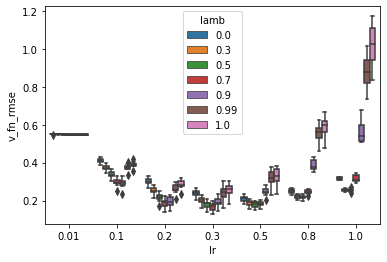

In [12]:
def lr_rmse_boxplot(data, x='lr', y='v_fn_rmse', hue='lamb', filters=None):
    # ==
    
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[hue] = [round(e, 3) for e in df[hue]]
    # hues
    n_hues = len(set(df[hue].values))
    c_palette = sns.color_palette("tab10", n_hues) 
    
    
    sns.boxplot(x=x, y=y, hue=hue,
                 palette=c_palette,
                 data=df)
    
lr_rmse_boxplot(episAvg_df)  # example

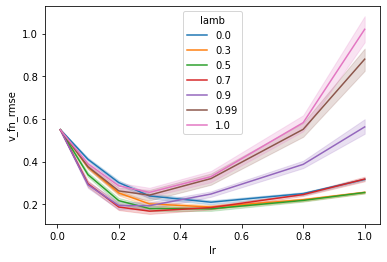

In [13]:
def lr_rmse_lineplot(data, x='lr', y='v_fn_rmse', hue='lamb', filters=None):
    # ==
    
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[hue] = [round(e, 3) for e in df[hue]]
    # hues
    n_hues = len(set(df[hue].values))
    c_palette = sns.color_palette("tab10", n_hues) 
    
    
    sns.lineplot(x=x, y=y, hue=hue,
                 ci=95,
                 palette=c_palette,
                 data=df)
    
lr_rmse_lineplot(episAvg_df)  # example

/Users/anthony/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


(0.0, 0.55)

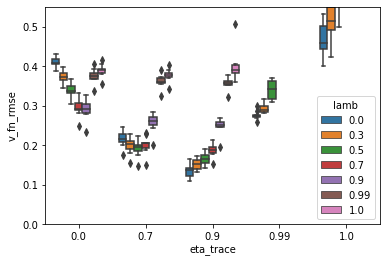

In [14]:
lr_rmse_boxplot(episAvg_df, x='eta_trace', filters={
    'agentCls_name': 'SFReturnAgent',
    'lr': 0.1,
    'use_true_sf_params': False,
    'use_true_reward_params': False,
})
plt.ylim([0,0.55])

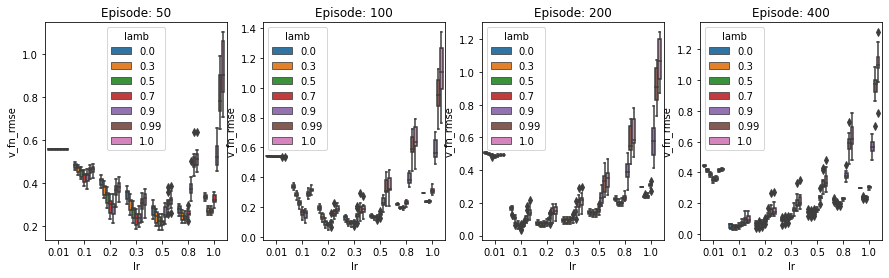

In [15]:
def script_plot_lr_rmse_boxplot_over_training(in_df, filters=None):
    # ==
    # s
    df = in_df.copy(deep=True)
    
    epis_to_plot = [50,100,200,400]
    avg_window_len = 50
    
    plt.figure(figsize=(15,4))
    
    for i, cur_epis_num in enumerate(epis_to_plot):
        cur_avg_df = get_RMSE_epis_averaged(df, episode_num=cur_epis_num, 
                                            average_window=avg_window_len)
        
        plt.subplot(1,len(epis_to_plot), i+1)
        lr_rmse_boxplot(cur_avg_df, y='v_fn_rmse', filters=filters)
        plt.title(f'Episode: {cur_epis_num}')
    
    
script_plot_lr_rmse_boxplot_over_training(Data_df)

Plot: AUC over all episodes

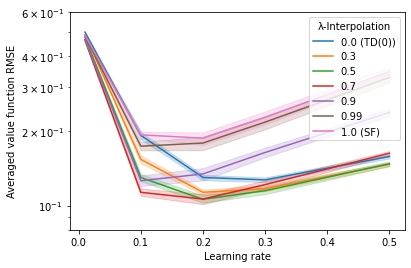

In [16]:
def script_plot_lr_rmse_lineplot_over_all_training(in_df):
    df = in_df.copy(deep=True)
    
    plt_hue='lamb'
    
    epis_to_plot = 400
    avg_window_len = 400
    
    # Get the averaged 
    cur_avg_df = get_RMSE_epis_averaged(df, episode_num=epis_to_plot, 
                                        average_window=avg_window_len)
    cur_avg_df = cur_avg_df[cur_avg_df['lr'] <= 0.5]
    
    # Filters
    cur_filters = {
        'agentCls_name': 'SFReturnAgent',
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
    
    # ==
    # Plot
    plt.figure(figsize=(6,4))

    lr_rmse_lineplot(cur_avg_df, y='v_fn_rmse', filters=cur_filters)
    plt.ylabel('Averaged value function RMSE')
    plt.xlabel('Learning rate')
    plt.yscale('log')
    
    plt.legend(['0.0 (TD(0))', '0.3', '0.5', '0.7', '0.9', '0.99', '1.0 (SF)'], 
               loc='upper right', title='λ-Interpolation')

    plt.ylim([0.08, 0.6])    
    
script_plot_lr_rmse_lineplot_over_all_training(Data_df)

In [17]:
sns.color_palette("colorblind", 10)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

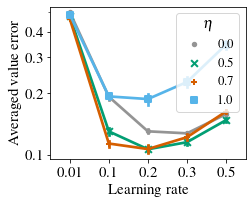

In [18]:
def script_plot_lr_rmse_pointplot_selected(in_df):
    df = in_df.copy(deep=True)
    
    hue='lamb'
    
    epis_to_plot = 400
    avg_window_len = 400
    
    # Get the averaged 
    cur_avg_df = get_RMSE_epis_averaged(df, episode_num=epis_to_plot, 
                                        average_window=avg_window_len)
    cur_avg_df = cur_avg_df[cur_avg_df['lr'] <= 0.5]
    
    # Filters
    cur_filters = {
        'agentCls_name': 'SFReturnAgent',
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
    for k in cur_filters:
        cur_avg_df = cur_avg_df[cur_avg_df[k] == cur_filters[k]]
    
    # ==
    # Plot
    # round and filter for lambdas
    cur_avg_df[hue] = [round(e, 3) for e in cur_avg_df[hue]]
    cur_avg_df = cur_avg_df[cur_avg_df['lamb'].isin([0.0, 0.5, 0.7, 1.0])]
    
    # create 10 color palette mapping
    c10pal = sns.color_palette("colorblind", 10)
    cmapping_keylist = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99, 1.0]
    cmapping_colidxs = [7, 1, 2, 3, 4, 6, 9]
    cmapping = {cmapping_keylist[i]: cmapping_colidxs[i] 
                for i in range(len(cmapping_keylist))}
    hue_val_list = sorted(list(set(cur_avg_df[hue].values)))  # current map
    c_palette = [c10pal[cmapping[hueVal]] for hueVal in hue_val_list]
    
    markers_map = {0.0: '.', 0.3: '.',0.5: 'x',0.7: '+',0.9: '.',
                   0.99: '.',1.0: 's'}
    markers_list = [markers_map[hueVal] for hueVal in hue_val_list]
    
    plt.figure(figsize=(3.5, 2.8))
    
    sns.pointplot(x='lr', y='v_fn_rmse', hue=hue,
                  ci=95, n_boot=300,
                  palette=c_palette,
                  markers=markers_list,
                  data=cur_avg_df)
    
    
    plt.ylabel('Averaged value error')
    plt.xlabel('Learning rate')
    
    plt.yscale('log')
    plt.ylim([0.095, 0.53])
    cur_yticks = [round(e, 3) for e in np.arange(0.1, 0.5, 0.1)]
    plt.yticks(cur_yticks, cur_yticks)
    
    
    
    # plt.legend(title='$\lambda$', loc='upper right', fontsize=13)
    plt.legend(title='$\eta$', loc='upper right', fontsize=13)


    
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 
                  'serif': ['Times'], 'size': 15})
    
script_plot_lr_rmse_pointplot_selected(Data_df)

plt.savefig('/Users/anthony/Desktop/random-chain_lr-study.pgf', bbox_inches="tight")

In [19]:
def get_averaged_best_rmse_param_df(in_df, filters=None):
    dep_col = 'v_fn_rmse'
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 
                  'use_true_sf_params', 'use_true_reward_params']
    search_cols = ['lr']
    
    # NOTE: no `lr` b.c. we want to find the best
    epis_to_plot = [400]
    avg_window_len = 400
    
    
    # ==
    # Search for best parameters 
    df = in_df.copy(deep=True)
    df_list = []
    
    for i, cur_epis_num in enumerate(epis_to_plot):
        cur_avg_df = get_RMSE_epis_averaged(df, episode_num=cur_epis_num, 
                                            average_window=avg_window_len)
        cur_idx = (cur_avg_df.groupby(indep_cols)[dep_col].transform(min) 
                   == cur_avg_df[dep_col])
        
        
        cur_filter_df = cur_avg_df[cur_idx].reset_index()
        idxs = (pd.merge(cur_avg_df, cur_filter_df, 
                         on=(indep_cols + search_cols), how='left', 
                         indicator=True)['_merge'] 
                == 'both')
        
        df_list.append(cur_avg_df[idxs])
    
    best_df = pd.concat(df_list, ignore_index=True)
    
    return best_df
    

avg_best_param_df = get_averaged_best_rmse_param_df(Data_df)
print(len(avg_best_param_df))
avg_best_param_df[0:2]

350


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,0.99,False,...,399,99.93,0.4875,0.117869,0.117869,0.0,0.029475,0.004365,0.000229,0.0
1,400,RandomWalkChainEnv,{},SFReturnAgent,2,1.0,0.01,0.0,1.00,False,...,399,99.93,0.4875,0.143527,0.143527,0.0,0.029475,0.005797,0.000229,0.0


In [20]:
def script_plt_best_param_boxplot(best_df):
    # ==
    plt_x = 'episode_idx'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    
    filters = {
        'agentCls_name': 'SFReturnAgent',
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
    
    df = best_df.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    # hues
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.boxplot(x=plt_x, y=plt_y, hue=plt_hue,
                 palette=c_palette,
                 data=df)
    
    
script_plt_best_param_boxplot(avg_best_param_df)

RuntimeError: latex was not able to process the following string:
b'episode_idx'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/anthony/.matplotlib/tex.cache/07f33607d85317e473c00c6b01f99d44.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/psnfss/ot1ptm.fd)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./07f33607d85317e473c00c6b01f99d44.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily episode_
                        idx}
No pages of output.
Transcript written on 07f33607d85317e473c00c6b01f99d44.log.




<Figure size 432x288 with 1 Axes>

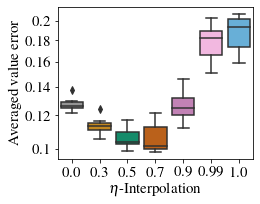

In [21]:
def script_plt_best_param_x_lamb_boxplot(best_df):
    # ==
    plt_x = 'lamb'
    plt_y = 'v_fn_rmse'
    
    filters = {
        'agentCls_name': 'SFReturnAgent',
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
    
    df = best_df.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
        
    # create 10 color palette mapping
    c10pal = sns.color_palette("colorblind", 10)
    cmapping_keylist = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99, 1.0]
    cmapping_colidxs = [7, 1, 2, 3, 4, 6, 9]
    cmapping = {cmapping_keylist[i]: cmapping_colidxs[i] 
                for i in range(len(cmapping_keylist))}
    hue_val_list = sorted(list(set(df[plt_x].values)))  # current map
    c_palette = [c10pal[cmapping[hueVal]] for hueVal in hue_val_list]
    
    
    plt.figure(figsize=(3.5, 2.8))
    sns.boxplot(x=plt_x, y=plt_y,
                palette=c_palette,
                data=df)
    plt.ylabel('Averaged value error')
    # plt.xlabel('$\lambda$-Interpolation')
    plt.xlabel('$\eta$-Interpolation')
    
    plt.yscale('log')
    cur_yticks = [round(e, 2) for e in np.arange(0.1, 0.21, 0.02)]
    plt.yticks(cur_yticks, cur_yticks)
    
    
    
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 
                  'serif': ['Times'], 'size': 15})
    
script_plt_best_param_x_lamb_boxplot(avg_best_param_df)
    
plt.savefig('/Users/anthony/Desktop/random-chain_best-per-lambda.pgf', bbox_inches="tight")

In [22]:
def script_helper_get_best_param_for_episode(best_df, episode_idx):
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 
                  'use_true_sf_params', 'use_true_reward_params', 'lr']
    
    df = best_df.copy(deep=True)
    df = df[df['episode_idx'] == episode_idx]
    
    return df.groupby(indep_cols).mean()

script_helper_get_best_param_for_episode(avg_best_param_df, 399)

num_episodes  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr                   
SFReturnAgent 0.00 0.00      False              False                  0.30           400   
                   0.70      False              False                  0.10           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   
              0.30 0.00      False              False                  0.20           400   
                   0.70      False              False                  0.10           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   
              0.50 0.00      False              False                  0.20           400   
                   0.70      False              False                  0.10           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   
              0.70 0.00      False              False                  0.20           400   
                   0.70      False              False                  0.10           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   
              0.90 0.00      False              False                  0.10           400   
                   0.70      False              False                  0.10           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   
              0.99 0.00      False              False                  0.20           400   
                   0.70      False              False                  0.10           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   
              1.00 0.00      False              False                  0.20           400   
                   0.70      False              False                  0.20           400   
                   0.90      False              False                  0.10           400   
                   0.99      False              False                  0.01           400   
                   1.00      False              False                  0.01           400   

                                                                             seed  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr           
SFReturnAgent 0.00 0.00      False              False                  0.30    11   
                   0.70      False              False                  0.10    11   
                   0.90      False              False                  0.10    11   
                   0.99      False              False                  0.01    11   
                   1.00      False              False                  0.01    11   
              0.30 0.00      False      

#### Learning dynamis

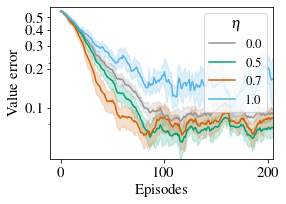

In [23]:
def script_plt_learning_over_epis(in_data_df, in_best_df, filters=None):
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 'lr',
                  'use_true_sf_params', 'use_true_reward_params']
    
    
    df = in_data_df.copy(deep=True)
    best_df = in_best_df.copy(deep=True)
    
    # Filter df
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    for k in filters:
        df = df[df[k] == filters[k]]
    df = df.reset_index()
    
    # Filter the oriingla full df with just the best params
    best_param_df = script_helper_get_best_param_for_episode(best_df, 
                                                             episode_idx=399)
    idxs = (pd.merge(df, best_param_df, 
                         on=indep_cols, how='left', 
                         indicator=True)['_merge'] 
                == 'both')
    df = df[idxs]
    
    plt_hue = 'lamb'
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    df = df[df['lamb'].isin([0.0, 0.5, 0.7, 1.0])]
    
    # Palette
    c10pal = sns.color_palette("colorblind", 10)
    cmapping_keylist = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99, 1.0]
    cmapping_colidxs = [7, 1, 2, 3, 4, 6, 9]
    cmapping = {cmapping_keylist[i]: cmapping_colidxs[i] 
                for i in range(len(cmapping_keylist))}
    hue_val_list = sorted(list(set(df[plt_hue].values)))  # current map
    c_palette = [c10pal[cmapping[hueVal]] for hueVal in hue_val_list]
    
    
    # ==
    # Plot
    plt.figure(figsize=(4,2.8))
    sns.lineplot(x='episode_idx', y='v_fn_rmse', hue=plt_hue, 
                 ci=95, n_boot=100,
                 palette=c_palette,
                 data=df)
    
    plt.xlim([-10, 205])
    plt.xlabel('Episodes')
    plt.ylabel('Value error')
    # plt.legend(title='$\lambda$', loc='upper right', fontsize=13)
    plt.legend(title='$\eta$', loc='upper right', fontsize=13)
    
    # plt.yscale('symlog', linscale=0.01)
    plt.yscale('log', base=3)
    plt.ylim([0.04, 0.6])
    cur_yticks = [round(e, 3) for e in np.arange(0.1, 0.6, 0.1)]
    plt.yticks(cur_yticks, cur_yticks)
    
    
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 
                  'serif': ['Times'], 'size': 15})
    
script_plt_learning_over_epis(Data_df, avg_best_param_df)

plt.savefig('/Users/anthony/Desktop/random-chain_learning-dynamics.pgf',  bbox_inches="tight")

#### Re-Plotting to save

In [51]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})


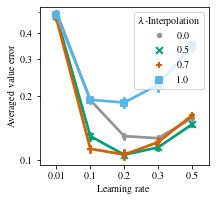

In [52]:
script_plot_lr_rmse_pointplot_selected(Data_df)
plt.tight_layout()
plt.savefig('/Users/anthony/Desktop/random-chain_lr-study.pgf')

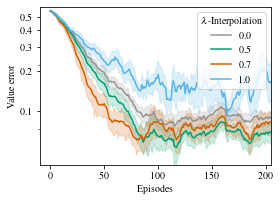

In [53]:
script_plt_learning_over_epis(Data_df, avg_best_param_df)
plt.tight_layout()
plt.savefig('/Users/anthony/Desktop/random-chain_learning-dynamics.pgf')

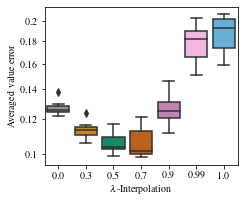

In [54]:
script_plt_best_param_x_lamb_boxplot(avg_best_param_df)
plt.tight_layout()
plt.savefig('/Users/anthony/Desktop/random-chain_best-per-lambda.pgf')